In [1]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd
from typing import Dict, Tuple
import subprocess
# --- Optional: load variables via your existing parser ---
try:
    from scripts.parse_vars import parse_variables
except Exception:  # pragma: no cover
    parse_variables = None


In [2]:

# ---- Configuration ---------------------------------------------------------
PATH_VARS = Path("../../geno_simulation.txt")
R_DIRECTORY = Path("../../rstudio_geno_simulation")

# Thresholds to categorize SNPs by MAF (adjust to match your study)
VERY_RARE = [0.0, 0.005]
RARE = [0.005, 0.01]
# Common is > 0.01

# Random seed for reproducibility of the flip step
RNG_SEED = 42


In [3]:
def load_config(path_vars: Path) -> Dict[str, int]:
    """Load scalar variables (G, L, c, k, M, etc.) from a text file parsed
    by your existing `parse_variables`. Falls back to environment defaults.
    """
    if parse_variables is None:
        raise RuntimeError(
            "`parse_variables` not available. Ensure scripts/parse_vars.py is importable."
        )
    variables = parse_variables(str(path_vars))
    # Cast all numeric-looking entries to int when possible
    cfg: Dict[str, int] = {}
    for k, v in variables.items():
        try:
            cfg[k] = int(v)
        except (TypeError, ValueError):
            # keep as-is if not int-like
            cfg[k] = v
    required = ["G", "L", "c", "k", "M", "F"]
    missing = [x for x in required if x not in cfg]
    if missing:
        raise KeyError(f"Missing required config keys: {missing}")
    return cfg


In [4]:
def read_simulated_genotypes(cfg: Dict[str, int]) -> pd.DataFrame:
    """Read the simulated genotype CSV produced by the R script, then delete it.
    Returns a DataFrame with genotype columns only; population labels are added later.
    """
    csv_name = R_FILE_STEM.format(**cfg)
    csv_path = R_DIRECTORY / csv_name
    if not csv_path.exists():
        raise FileNotFoundError(f"Expected file not found: {csv_path}")
    df = pd.read_csv(csv_path)
    # Clean up the file after load (optional)
    try:
        csv_path.unlink(missing_ok=True)
    except Exception:
        pass
    return df


In [5]:
def attach_populations(n_rows: int, k: int, c: int) -> pd.DataFrame:
    """Construct a populations DataFrame with balanced groups.
    Pop IDs go from 1..k*k, each repeated c times.
    """
    num_pops = k * k
    expected_rows = num_pops * c
    if n_rows != expected_rows:
        raise ValueError(
            f"Row count {n_rows} != expected k*k*c = {expected_rows}. Check inputs."
        )
    pops = np.repeat(np.arange(1, num_pops + 1), c)
    return pd.DataFrame({"populations": pops})

In [6]:
def compute_human_metadata(populations: pd.Series, k: int) -> pd.DataFrame:
    """Compute per-individual metadata (grid coordinates, scaled population index).
    Adds x, y (1-based grid), z (0 placeholder), and population_fraction.
    """
    pops = populations.astype(int)
    x = ((pops - 1) % k) + 1
    y = ((pops - 1) // k) + 1
    z = np.zeros_like(x)
    population_fraction = pops / (k * k)
    return pd.DataFrame({
        "populations": pops,
        "x": x,
        "y": y,
        "z": z,
        "population": population_fraction,
    })

In [7]:
def add_rgb_from_xyz(df_xyz: pd.DataFrame) -> pd.DataFrame:
    """Add normalized RGB columns from x,y,z in a vectorized manner (safe for zeros)."""
    x = df_xyz["x"].to_numpy()
    y = df_xyz["y"].to_numpy()
    z = df_xyz["z"].to_numpy()
    r_den = np.max(x) if np.max(x) != 0 else 1
    g_den = np.max(y) if np.max(y) != 0 else 1
    b_den = np.max(z) if np.max(z) != 0 else 1
    return df_xyz.assign(
        r = x / r_den,
        g = y / g_den,
        b = z / b_den,
    )

In [8]:
def compute_maf(snps: pd.DataFrame) -> pd.Series:
    """Minor allele frequency per SNP assuming 0/1/2 encoding and diploidy."""
    G = snps.to_numpy()
    n_individuals = G.shape[0]
    allele_sum = G.sum(axis=0)  # total minor alleles across individuals
    af = allele_sum / (2.0 * n_individuals)
    maf = np.minimum(af, 1.0 - af)
    return pd.Series(maf, index=snps.columns, name="MAF")


In [9]:
def categorize_by_maf(maf: pd.Series) -> pd.Series:
    """Categorize SNPs into very_rare, rare, common by MAF thresholds."""
    bins = [-1e-9, 0.005, 0.01, 1.0]
    labels = ["very_rare", "rare", "common"]
    return pd.cut(maf, bins=bins, labels=labels, include_lowest=True)



In [10]:
rng = np.random.default_rng(RNG_SEED)

In [13]:
cfg = load_config(PATH_VARS)
G = int(cfg["G"]); L = int(cfg["L"]); c = int(cfg["c"]); k = int(cfg["k"]); M = float(cfg["M"]); F = float(cfg["F"])

R_DIRECTORY = Path("../../rstudio_geno_simulation")
R_SCRIPT = "create_geno.R"
# but when building filenames, strip trailing .0
def format_M(M):
    return str(int(M)) if M.is_integer() else str(M)

CSV_STEM = "simulated_genotypes_G{G}_L{L}_c{c}_k{k}_M{M}.csv"


In [14]:
cfg

{'G': 200,
 'L': 200,
 'c': 20,
 'k': 10,
 'M': 0,
 'HWE': 1,
 'nr_humans': 2000,
 'nr_snps': 2000,
 'bottleneck_nr': 64,
 'very_rare_threshold_L': 0,
 'very_rare_threshold_H': 0,
 'rare_threshold_L': 0,
 'rare_threshold_H': 0,
 'common_threshold_L': 0,
 'common_threshold_H': 0,
 'F': 0}

In [11]:



def run_r_generation(G, L, c, k, M):
    r_expr = (
        f"G <- {G}; L <- {L}; c <- {c}; k <- {k}; M <- {format_M(M)};"
        f"source('{R_SCRIPT}', echo=TRUE)"
    )
    res = subprocess.run(
        ["Rscript", "-e", r_expr],
        capture_output=True,
        text=True,
        cwd=str(R_DIRECTORY),   # << safer than setwd() inside R
    )
    if res.returncode != 0:
        raise RuntimeError(f"R failed.\nSTDOUT:\n{res.stdout}\n\nSTDERR:\n{res.stderr}")
    return res

def read_generated_csv(G, L, c, k, M):
    csv_path = R_DIRECTORY / CSV_STEM.format(G=G, L=L, c=c, k=k, M=format_M(M))
    if not csv_path.exists():
        raise FileNotFoundError(f"Expected file not found: {csv_path}")
    df = pd.read_csv(csv_path)
    return df


In [12]:
run_r_generation(G, L, c, k, M)
raw = read_generated_csv(G, L, c, k, M)


KeyboardInterrupt: 

In [13]:
humans = attach_populations(n_rows=len(raw), k=k, c=c)


In [14]:
# Ensure genotype-only frame first (keeps original column order)
snp_cols = list(raw.columns)
snps = raw[snp_cols].copy()

In [15]:
snps['populations'] = list(humans['populations'])

In [ ]:
complete = []

unique_pops = snps['populations'].unique()
snp_cols = snps.columns[:-1]  # Assumes 'populations' is the last column

for pop in unique_pops:
    pop_df = snps[snps['populations'] == pop]

    # Flip one random genotype per SNP
    for col in snp_cols:
        idx = np.random.choice(pop_df.index)
        pop_df.loc[idx, col] = 1 - pop_df.loc[idx, col]  # Flip 0↔1

    # Estimate MAF q
    q_values = pop_df[snp_cols].mean()

    # Simulate genotypes
    n_individuals = len(pop_df)
    genotype_matrix = np.zeros((n_individuals, len(snp_cols)), dtype=int)
    
    for i, snp in enumerate(snp_cols):
        q = q_values[snp]
        p = 1 - q
        probs = np.array([q**2 + F*p*q, 2*p*q*(1 - F), p**2 + F*p*q])
        probs /= probs.sum()
        genotype_matrix[:, i] = np.random.choice([-1, 0, 1], size=n_individuals, p=probs)

    pop_df.loc[:, snp_cols] = genotype_matrix
    complete.append(pop_df)

# Combine all populations
complete = pd.concat(complete, ignore_index=True)
N = len(complete)

# Flip alleles so that MAF <= 0.5 and compute MAFs
maf_values = {}
for snp in snp_cols:
    genos = complete[snp]
    maf = (2 * (genos == -1).sum() + (genos == 0).sum()) / (2 * N)
    if maf > 0.5:
        complete[snp] = genos.replace({-1: 1, 1: -1})
        maf = 1 - maf
    maf_values[snp] = maf

# Sort SNPs by descending MAF
sorted_snps = sorted(maf_values.items(), key=lambda x: x[1], reverse=True)

# Create new column names: V1_MAF_0.489, etc.
new_col_names = {}
for i, (snp, maf) in enumerate(sorted_snps):
    new_name = f"{i+1}_MAF_{maf:.3f}"
    new_col_names[snp] = new_name

# Rename and reorder SNP columns
complete.rename(columns=new_col_names, inplace=True)
ordered_cols = list(new_col_names.values()) + ['populations']
complete = complete[ordered_cols]

In [ ]:
humans_meta = compute_human_metadata(humans["populations"], k=k)
humans_meta = add_rgb_from_xyz(humans_meta)

# Create population labels

In [11]:
humans = humans.copy()
# Convert and calculate coordinates safely using .loc
humans.loc[:, 'populations'] = humans['populations'].astype(int)
humans.loc[:, 'x'] = ((humans['populations'] - 1) % k) + 1
humans.loc[:, 'y'] = ((humans['populations'] - 1) // k) + 1
humans.loc[:, 'z'] = F
humans.loc[:, 'population'] = humans['populations'] / (k * k)


In [12]:
# Sort columns by MAF
# Initialize lists to hold the DataFrames
very_rare_cols = []
rare_cols = []
common_cols = []

# Categorize columns based on allele frequency
for col in complete.columns:
    af_value = float(col.split('_')[2])
    if very_rare_threshold_L < af_value <= very_rare_threshold_H:
        very_rare_cols.append(complete[[col]].rename(columns={col: 'VR_' + col}))
    elif rare_threshold_L < af_value <= rare_threshold_H:
        rare_cols.append(complete[[col]].rename(columns={col: 'R_' + col}))
    elif common_threshold_L < af_value <= common_threshold_H:
        common_cols.append(complete[[col]].rename(columns={col: 'C_' + col}))

# Concatenate all collected DataFrames at once
very_rare = pd.concat(very_rare_cols, axis=1) if very_rare_cols else pd.DataFrame()
rare = pd.concat(rare_cols, axis=1) if rare_cols else pd.DataFrame()
common = pd.concat(common_cols, axis=1) if common_cols else pd.DataFrame()

# Concatenate the final DataFrame
complete = pd.concat([common, rare, very_rare], axis=1)

# Vizualize populations through PCA

In [13]:
try:
    scaler = StandardScaler()
    scaled_complete = scaler.fit_transform(complete)
    n_components = max(min(complete.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_complete = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_complete = pca.fit_transform(scaled_complete)
    PC_complete = pd.DataFrame(data=PC_complete, columns=pc_labels_complete)

except:
    print("nothing in complete")
    PC_complete = pd.DataFrame(np.zeros((len(complete), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_common = scaler.fit_transform(common)
    n_components = max(min(common.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_common = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_common = pca.fit_transform(scaled_common)
    PC_common = pd.DataFrame(data=PC_common, columns=pc_labels_common)
except:
    print("common is empty")
    PC_common = pd.DataFrame(np.zeros((len(common), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_rare = scaler.fit_transform(rare)
    n_components = max(min(rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_rare = pca.fit_transform(scaled_rare)
    PC_rare = pd.DataFrame(data=PC_rare, columns=pc_labels_rare)
except:
    print("rare is empty")
    PC_rare = pd.DataFrame(np.zeros((len(rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])
    
try:
    scaler = StandardScaler()
    scaled_veryrare = scaler.fit_transform(very_rare)
    n_components = max(min(very_rare.shape[1], 50), 4)
    pca = PCA(n_components=n_components)
    pc_labels_very_rare = [f"PC{i}" for i in range(1, n_components + 1)]
    PC_veryrare = pca.fit_transform(scaled_veryrare)
    PC_veryrare = pd.DataFrame(data=PC_veryrare, columns=pc_labels_very_rare)
except:
    print("very rare is empty")
    PC_veryrare = pd.DataFrame(np.zeros((len(very_rare), 4)), columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [14]:
to_have_collumns = ['populations', 'x', 'y', 'population']
PC_complete[to_have_collumns] = humans[to_have_collumns]
PC_common[to_have_collumns] = humans[to_have_collumns]
PC_rare[to_have_collumns] = humans[to_have_collumns]
PC_veryrare[to_have_collumns] = humans[to_have_collumns]

In [15]:
number_of_snps = complete.shape[1]
number_of_individuals = complete.shape[0]

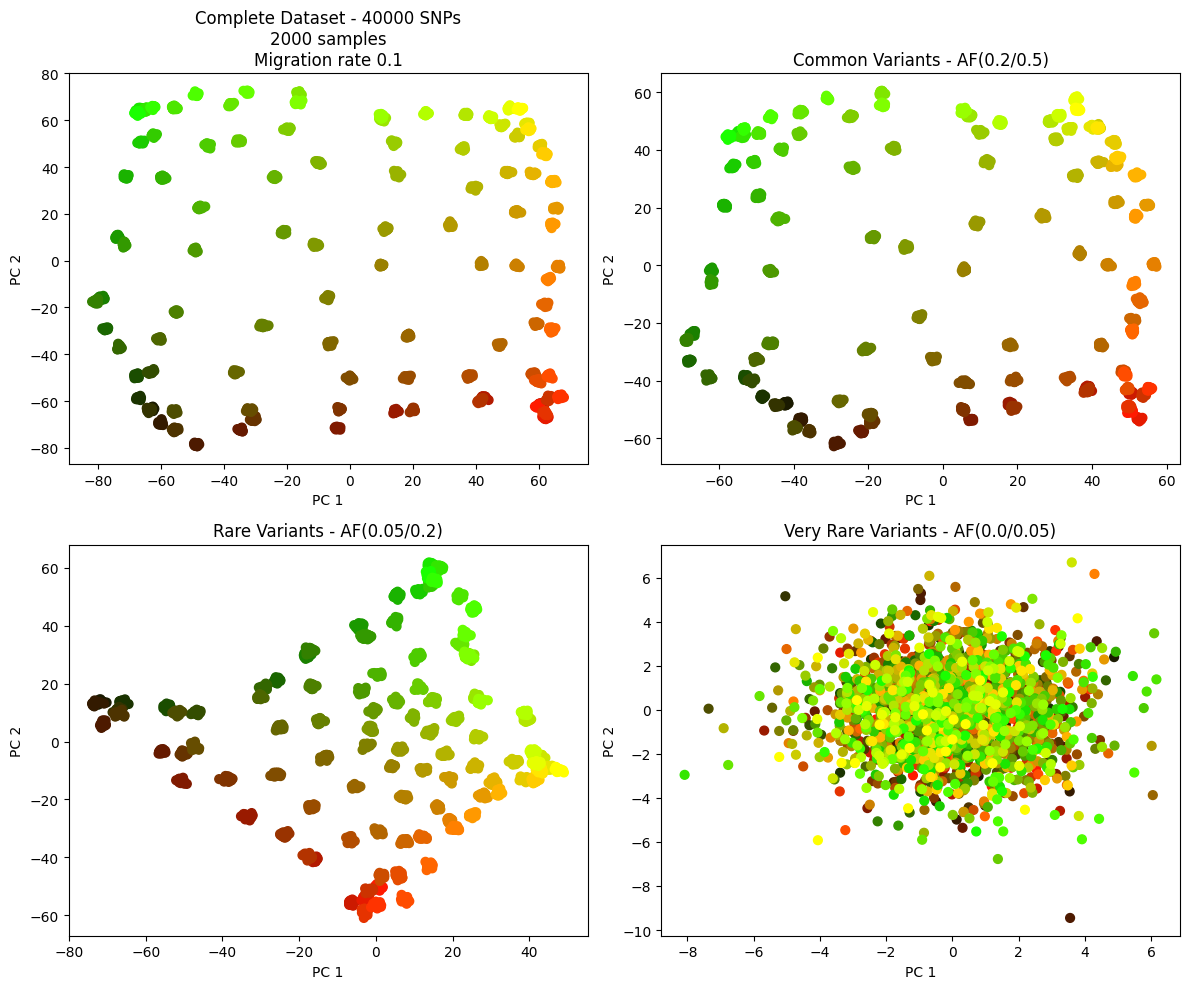

In [16]:
# Generate color mapping for the 'humans' DataFrame
colors = [map_to_color(x, y, z, humans) for x, y, z in zip(humans['x'], humans['y'], humans['z'])]
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
          f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
          f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
          f"Very Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]

# Iterate through dataframes, axes, and titles
for df, ax, title in zip(dataframes, axes.flatten(), titles):
    # Count the unique values in the 'populations' column
    unique_populations = df['populations'].nunique()
    # Plotting the principal components with colors
    ax.scatter(x=df['PC1'], y=df['PC2'], c=colors, s=40)
    
    ax.set_title(title)  # Set the title for the current subplot
    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend([],[], frameon=False) # This hides the legend

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
plt.close()

# Save data

In [17]:
path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/genotype"
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{F}/phenotype/"
os.makedirs(path_geno, exist_ok = True)
os.makedirs(path_pheno,exist_ok=True)

In [18]:
complete.to_pickle(f"{path_geno}/complete_inbred.pkl")
humans[['populations', 'x','y']].to_pickle(f"{path_pheno}/inbred_humans.pkl")